# Imports

In [3]:
import trièst
from time import time

import json, csv
import matplotlib.pyplot as plt

# Project description

The following project consisted in reproducing the result of the paper 'TRIÈST: Counting Local and Global Triangles in
Fully-Dynamic Streams with Fixed Memory Size' that proposes a series of stream based algorithms to estimate the number of triangles that are present in a graph where edges are added (or removed) in a dynamic way.

The initial part consisted in implementing the reservoir sampling function, and then incorporate it into the main algorithm to estimate the triangles in a graph.

## Reservoir sampling

Reservoir sampling is an efficient way of of keeping a limited amount of samples from the datastream. It is designed in a way that makes sure that each element in the stream has the same probability of being drawn (s/n where n is the n-th element in the stream and s is the size of the reservoir).
The algorithm works in this way:
1. Store all the first s elements inside the stream
2. When a new element arrives, throw a biased dice with probability of head being s/n. 
    - If it's head, then substitute one of the elements inside the reservoir drawing from a uniform distribution.
    - Else, discard the element.

This allows us to keep a sample of variable size of the stream, based on our memory needs. This method is useful in many data stream applications, where it is unfeasible to store all the elements of the stream into memory.

## Trièst 

In the paper mentioned above, the authors propose some methods whose goal is to perform an estimate on the number of global and local triangles in a graph where edges are added dynamically. 
All the algorithms are based on reservoir sampling, that allows to store just a limited part of the graph as opposed to every single edge.

The authors propose 3 algorithms in total, but we decided to implement only the first 2, namely "trièst-base" and "trièst-impr". 
They work in a similar way.
- Initialize the following variables:
    - M --> number of elements in the reservoir (the more elements the more accurate estimate)
    - S --> ordered list containing the edges (tutples of nodes) that we sample from the stream (it's the reservoir). We will use this as the sampled portion of the graph we are considering.
    - N --> dict node:set(nodes), it has a node as a key and the valuea are a set of nodes that share an edge with the node in the key
    - t_global --> counter for the estimate of the global number of triangles 
    - t_local --> counter for the local number of triangles for every node
- When a new edge arrives, it is either kept inside S, or discarded using reservoir sampling. 
- if the edge is kept then store it in S, update N and call the function update_counters
    - update_counters is what differentiates "trièst-base" from "trièt-impr" (pseudocodes in the next cell).
    - another major difference between the 2 is that in the first algorithm we update the counters when a substitution happens in S (with a negative sign), while in the second algorithm we only add values to the counters.

In the following report we make a comparison of the 2 methods and evaluate how good they are at estimating the number of triangles in relation to the size of the reservoir.

<p float="top">
  <img src="pics/base.png" width="522" />
  <img src="pics/impr.png" width="700" /> 
</p>

# Data Loading

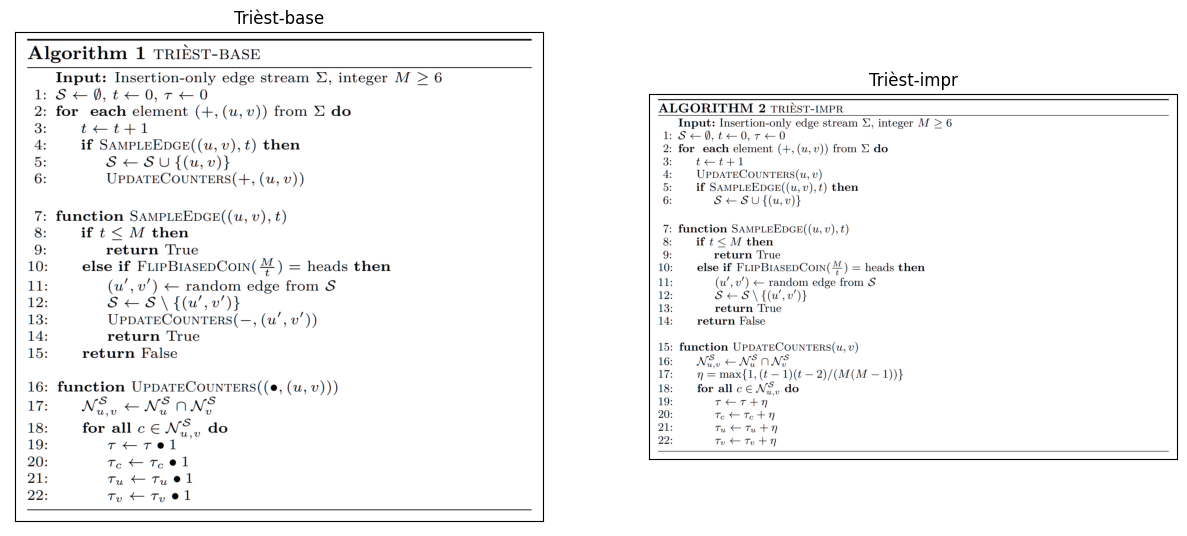

In [73]:
def load_data(filename: str) -> list[tuple[int, int]]:
    '''Load data from file and return it as a list of frozensets.'''
    with open(f'data/{filename}/{filename}_edges.csv', newline='') as csvfile:
        edges_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        edges = [(int(a), int(b)) for a, b in list(edges_reader)[1:]]
    return edges

def triangles_count(edges: list[tuple[int, int]]) -> int:
    '''generates a networkx graph using the first T edges and returns the number of triangles in it'''
    import networkx as nx

    G = nx.Graph()
    G.add_edges_from(edges)
    triangles = nx.triangles(G).values()
    return triangles

# Trièst algorithms

In [74]:
from importlib import reload
trièst = reload(trièst)  # to reload the code 

Data has been loaded!
It has 92752 edges


100%|██████████| 90000/90000 [00:00<00:00, 422222.23it/s]


Data has been loaded!
It has 92752 edges


100%|██████████| 90000/90000 [00:00<00:00, 406097.32it/s]


Estimated number of triangles using trièst-base: 6979
Time required: 0.21617650985717773 seconds

Estimated number of triangles using trièst-impr: 41264
Time required: 0.37137627601623535 seconds

Number of triangles in the graph: 41521
Time required: 0.828991174697876


In [75]:
'''
dataset links:
 - large_twitch -> https://snap.stanford.edu/data/twitch_gamers.html
 - deezer_europe -> https://snap.stanford.edu/data/feather-deezer-social.html
'''

graph_name = 'deezer_europe'
data = load_data(graph_name)

# number of edges 
T = 90_000 
# dimension of the reservoir 
M = 50_000

# trièst-base
s = time()
t_base, _ = trièst.TrièstBase(M)(data[:T])
base_time = time() - s

# trièst-impr
s = time()
t_impr, _ = trièst.TrièstImpr(M)(data[:T])
impr_time = time() - s

# networkx 
s = time()
triangles = triangles_count(data[:T])
count_time = time() - s

print(f'Estimated number of triangles using trièst-base: {t_base}\nTime required: {base_time} seconds\n')
print(f'Estimated number of triangles using trièst-impr: {t_impr}\nTime required: {impr_time} seconds\n')
print(f'Number of triangles in the graph: {sum(triangles) // 3}\nTime required: {count_time}') # type: ignores


90000it [00:00, 275632.98it/s]
90000it [00:00, 280032.02it/s]


Estimated number of triangles using trièst-base: 6979
Time required: 0.3391458988189697 seconds

Estimated number of triangles using trièst-impr: 41264
Time required: 0.332150936126709 seconds

Number of triangles in the graph: 41521
Time required: 0.8095149993896484


# Accuracy in the estimate on the number of triangles and time comparison

In [85]:
d = {
        'large_twitch': {
            'T': 500_000,
            'M': [1_000, 2_000, 5_000, 10_000, 25_000, 50_000, 100_000, 200_000, 500_000],
            't_base': {
                'time': [],
                'triangles': []
            },
            't_impr': {
                'time': [],
                'triangles': []
            }
        }, 
        'deezer_europe': {
            'T': 90_000,
            'M': [200, 500, 1_000, 1_500, 2_000, 4_000, 10000, 15_000, 20_000, 90_000],
            't_base': {
                'time': [],
                'triangles': []
            },
            't_impr': {
                'time': [],
                'triangles': []
            }
        }
    }
for graph_name in d.keys():
    T = d[graph_name]['T']
    data = load_data(graph_name)
    data_slice = data[:T]
    # networkx
    s = time()
    triangles = triangles_count(data_slice)
    count_time = time() - s

    d[graph_name]['true_triangle_count'] = sum(triangles) // 3
    d[graph_name]['count_time'] = count_time
    
    for m in d[graph_name]['M']:

        # trièst-base
        s = time()
        t_base, _ = trièst.TrièstBase(m)(data_slice)
        base_time = time() - s
        d[graph_name]['t_base']['time'].append(base_time)
        d[graph_name]['t_base']['triangles'].append(t_base)
        
        # trièst-impr
        s = time()
        t_impr, _ = trièst.TrièstImpr(m)(data_slice)
        impr_time = time() - s
        d[graph_name]['t_impr']['time'].append(impr_time)
        d[graph_name]['t_impr']['triangles'].append(t_impr)

# save d in json file
with open('results.json', 'w') as f:
    json.dump(d, f, indent=4)


500000it [00:00, 970907.30it/s] 
500000it [00:00, 534164.16it/s]
500000it [00:00, 1109160.57it/s]
500000it [00:01, 435515.47it/s]
500000it [00:00, 1036725.19it/s]
500000it [00:00, 526949.75it/s]
500000it [00:00, 1025594.48it/s]
500000it [00:01, 487190.74it/s]
500000it [00:00, 778120.41it/s]
500000it [00:01, 438179.85it/s]
500000it [00:00, 547373.48it/s]
500000it [00:04, 123938.87it/s]
500000it [00:01, 395635.68it/s]
500000it [00:01, 253253.93it/s]
500000it [00:02, 209654.34it/s]
500000it [00:02, 212760.27it/s]
500000it [00:02, 245893.34it/s]
500000it [00:02, 204302.03it/s]
90000it [00:00, 1210962.74it/s]
90000it [00:00, 512533.89it/s]
90000it [00:00, 1097883.15it/s]
90000it [00:00, 433517.30it/s]
90000it [00:00, 519966.50it/s]
90000it [00:00, 358165.75it/s]
90000it [00:00, 879112.43it/s]
90000it [00:00, 191179.79it/s]
90000it [00:00, 440278.57it/s]
90000it [00:00, 307579.72it/s]
90000it [00:00, 678614.32it/s]
90000it [00:00, 393167.67it/s]
90000it [00:00, 490590.56it/s]
90000it [00:00,

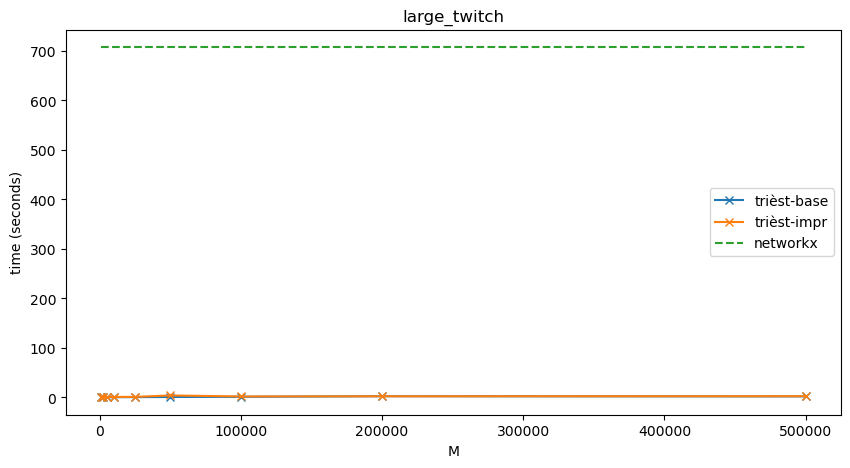

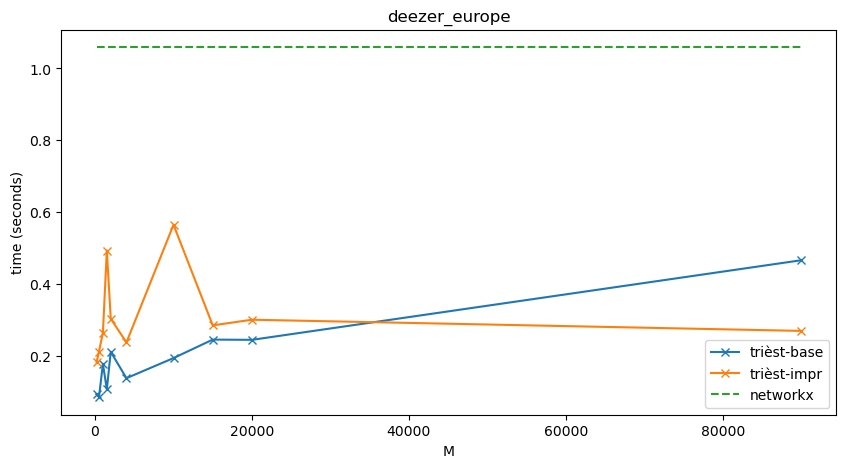

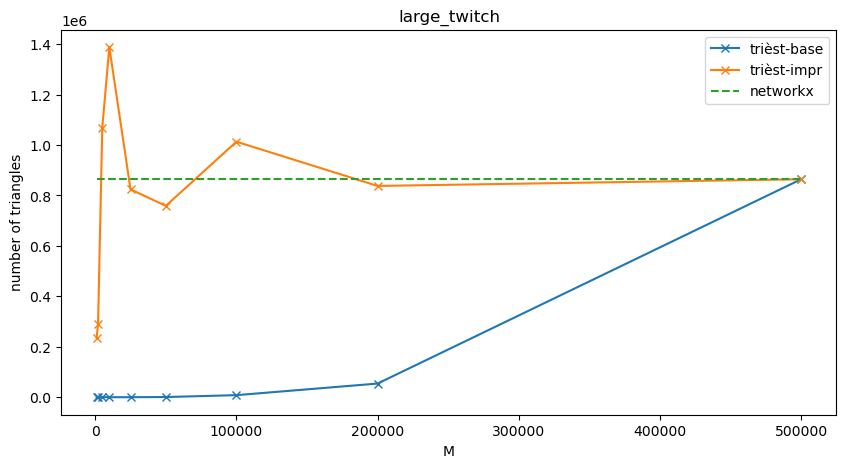

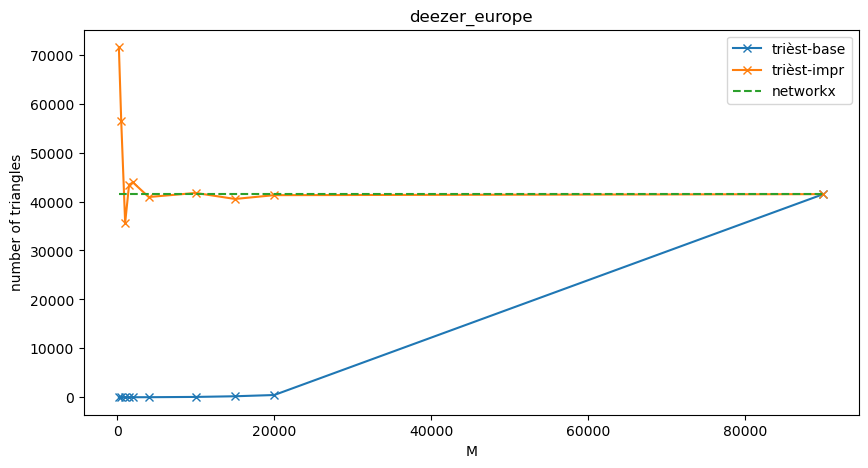

In [86]:
# load d from json file
with open('results.json', 'r') as f:
    d = json.load(f)

# plot how much time trièst-base and trièst-impr take to estimate the number of triangles
for graph_name in d.keys():
    plt.figure(figsize=(10, 5))
    plt.title(f'{graph_name}')
    plt.xlabel('M')
    plt.ylabel('time (seconds)')
    plt.plot(d[graph_name]['M'], d[graph_name]['t_base']['time'], '-x', label='trièst-base')
    plt.plot(d[graph_name]['M'], d[graph_name]['t_impr']['time'], '-x', label='trièst-impr')
    # plt const line
    plt.plot(d[graph_name]['M'], [d[graph_name]['count_time']] * len(d[graph_name]['M']), '--', label='networkx')
    plt.legend()
    plt.show()

# plot the number of triangles estimated by trièst-base and trièst-impr
for graph_name in d.keys():
    plt.figure(figsize=(10, 5))
    plt.title(f'{graph_name}')
    plt.xlabel('M')
    plt.ylabel('number of triangles')
    plt.plot(d[graph_name]['M'], d[graph_name]['t_base']['triangles'], '-x', label='trièst-base')
    plt.plot(d[graph_name]['M'], d[graph_name]['t_impr']['triangles'], '-x', label='trièst-impr')
    # plt const line
    plt.plot(d[graph_name]['M'], [d[graph_name]['true_triangle_count']] * len(d[graph_name]['M']), '--', label='networkx')
    plt.legend()
    plt.show()

# Bonus tasks:
### What were the challenges you faced when implementing the algorithm?
The algorithm is based on reservoir sampling, which is fairly straightforward to implement. The implementation of the trièst algorithms was also quite simple, the hardest part was probably to write the update_counters function.
### Can the algorithm be easily parallelized? If yes, how? If not, why? Explain.
The algorithmn can't really be parallelized, as it is made to be used in a dynamic scenario, when edges are added and removed to the graph in a continuous manner, and consequently update the counters for the estimates of the number of triangles. Maybe in the second algorithm there might be some steps that can be parallelized, when we remove the nodes from N and we add the new ones; however the gain would be too small and it would not change much the efficiency of the algorithm.
### Does the algorithm work for unbounded graph streams? Explain.
Yes, the algorithm works even for unbounded graph streams, as the samples in the reservoir will continuosly be updated as more edges are added to the graph. However, we have to say that the estimate in the number of triangles will be strongly influenced by the number of element that the reservoir can hold. The more edges the graph is made of, the more values need to be stored in the reservoir in order to have a better estimate.
### Does the algorithm support edge deletions? If not, what modification would it need? Explain.
No, as also explained by the authors, the base forms of the 2 algorithms we implemented do not work for edge deletion, howerever, there is a third algorithm of the trièst family that works in this type of situations.
The problem with deletions is that there it can be complicated to make it work with the reservoir, as we can only store edges that are supposedly in the graph and if they are deleted there is not a direct way of addressing this issue using the base form of Random Sampling. 
One thing to observe, however, is that edges that are removed will more likely be compensated in the future by other added edged. They use a method called random pairing (RP), which makes use of 2 counters that keep track on the number of uncompensated edge deletions involving an edge that was or was not in S at the time of deletion.
Consequently, these counter are used to implement a slight modification of reservoir sampling, where they use the standard algorithm if the sum of the counter is 0 (all the deletions have been compensated), or uses a different probability (di / (d0 + di) instead of M/t) when deciding wheter to keep a new edge or not.
This allows to handle the fact that edges are deleted and can give an efficient method that works also in this situation.